# Group Project Proposal 
##### Group Number: 141  Group Members: Matilde Galantino, Jacob Guglielmin, Phoenix Jin, Amy Wong 

### Title: The relationship between various socioeconomic factors and life expectancy at birth

### Introduction
#### Background 

to do 

### Preliminary exploratory data analysis

##### **Run the following cell before continuing further - set** `need_install = TRUE` **if either tidyverse or tidymodels are not installed on your system:**

In [1]:
need_install = FALSE

if (need_install) install.packages(c("tidyverse", "tidymodels"))

library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Read in data from the web:

##### We are reading this data from GitHub, as we downloaded the data manually and uploaded the data we require since much of the data came packaged in a .zip file rather than available as a raw .csv. In addition, we can ensure that these links remain available, unlike the links of the original publishers.

In [2]:
# Download data
hdi_composite_data_raw <- read_csv("https://raw.githubusercontent.com/phoenixjin8/dsci100-group-project/main/data/hdr_composite_index.csv", show_col_types = FALSE)
poverty_rate_data_raw <- read_csv("https://raw.githubusercontent.com/phoenixjin8/dsci100-group-project/main/data/poverty_rate.csv", skip = 4, show_col_types = FALSE)

hdi_composite_data_raw
poverty_rate_data_raw

iso3,country,hdicode,region,hdi_rank_2021,hdi_1990,hdi_1991,hdi_1992,hdi_1993,hdi_1994,⋯,mf_2012,mf_2013,mf_2014,mf_2015,mf_2016,mf_2017,mf_2018,mf_2019,mf_2020,mf_2021
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Afghanistan,Low,SA,180,0.273,0.279,0.287,0.297,0.292,⋯,1.86,1.88,1.66,1.62,1.66,1.41,1.32,1.38,1.38,1.38
AGO,Angola,Medium,SSA,148,NA,NA,NA,NA,NA,⋯,4.09,4.53,3.97,3.59,2.79,2.64,2.28,2.18,2.18,2.18
ALB,Albania,High,ECA,67,0.647,0.629,0.614,0.617,0.624,⋯,12.44,11.49,13.14,12.61,14.39,14.46,12.85,12.96,12.96,12.96
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ZAF,South Africa,High,SSA,109,0.632,0.641,0.647,0.652,0.658,⋯,9.55,10.09,8.41,8.06,7.55,7.76,7.60,7.55,7.55,7.55
ZMB,Zambia,Medium,SSA,154,0.412,0.408,0.408,0.414,0.411,⋯,4.74,4.68,3.92,3.36,3.12,3.21,2.80,2.38,2.38,2.38
ZWE,Zimbabwe,Medium,SSA,146,0.509,0.512,0.498,0.491,0.486,⋯,3.13,2.86,3.03,2.66,2.29,2.26,2.05,1.21,1.21,1.21


country_name,country_code,development,indicator_name,indicator_code,1960,1961,1962,1963,1964,⋯,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Aruba,ABW,NA,Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population),SI.POV.UMIC,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Afghanistan,AFG,Low,Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population),SI.POV.UMIC,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Angola,AGO,Medium,Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population),SI.POV.UMIC,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,78,NA,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
South Africa,ZAF,High,Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population),SI.POV.UMIC,NA,NA,NA,NA,NA,⋯,NA,NA,61.6,NA,NA,NA,NA,NA,NA,NA
Zambia,ZMB,Medium,Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population),SI.POV.UMIC,NA,NA,NA,NA,NA,⋯,NA,NA,NA,90.7,NA,NA,NA,NA,NA,NA
Zimbabwe,ZWE,Medium,Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population),SI.POV.UMIC,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,84.1,NA,85,NA,NA


### Clean and wrangle data into a tidy format:

In [3]:
# Tidy poverty rate data
poverty_rate_data <- poverty_rate_data_raw
poverty_rate_data <- poverty_rate_data |>
    select(-country_name, -indicator_name, -indicator_code, -development) |>
    pivot_longer(c(-country_code), names_to = "year", values_to = "poverty_rate") |>
    filter(!is.na(poverty_rate))

# Tidy HDI data
# Eliminate irrelevant columns
hdi_composite_data_relevant <- hdi_composite_data_raw |>
    select(-country, -hdicode, -region, -hdi_rank_2021)
# We will write to a new dataframe rather than edit the existing one since the raw data is horrific to work with
# Extract CO2 emissions data and country codes
hdi_composite_data <- hdi_composite_data_relevant |>
    select(iso3, co2_prod_1990:co2_prod_2021) |>
    # Remove all information from column name except the year (change each column name to the last 4 characters of itself, ignore "iso3")
    rename_with(function(x){ifelse(x == "iso3", "iso3", substring(x, nchar(x) - 3))}) |>
    pivot_longer(-iso3, names_to = "year", values_to = "co2_per_capita")
# Extract mean years of schooling data
hdi_composite_data <- merge(hdi_composite_data,
                            (hdi_composite_data_relevant |>
                             select(iso3, mys_1990:mys_2021) |>
                             rename_with(function(x){ifelse(x == "iso3", "iso3", substring(x, nchar(x) - 3))}) |>
                             pivot_longer(-iso3, names_to = "year", values_to = "mean_schooling")))
# Extract GNI per capita data
hdi_composite_data <- merge(hdi_composite_data,
                            (hdi_composite_data_relevant |>
                             select(iso3, gnipc_1990:gnipc_2021) |>
                             rename_with(function(x){ifelse(x == "iso3", "iso3", substring(x, nchar(x) - 3))}) |>
                             pivot_longer(-iso3, names_to = "year", values_to = "gni_per_capita")))
# Extract life expectancy data
hdi_composite_data <- merge(hdi_composite_data,
                            (hdi_composite_data_relevant |>
                             select(iso3, le_1990:le_2021) |>
                             rename_with(function(x){ifelse(x == "iso3", "iso3", substring(x, nchar(x) - 3))}) |>
                             pivot_longer(-iso3, names_to = "year", values_to = "life_expectancy")))

# Merge HDI data with poverty rate data and convert year to a number
tidy_data <- merge(poverty_rate_data, hdi_composite_data, by.x = c("country_code", "year"), by.y = c("iso3", "year"), all = TRUE) |>
    mutate(year = as.numeric(year))

# Add development rating
tidy_data <- left_join(tidy_data, select(poverty_rate_data_raw, country_code, development), by = "country_code") |>
    mutate(development = as.factor(development))

# Reorder the columns to make sense
tidy_data <- tidy_data[,c("country_code", "development", "year", "life_expectancy", "gni_per_capita", "poverty_rate", "mean_schooling", "co2_per_capita")] |>
    
# Remove the 4 data points that are WAY out the bottom of the life expectancy chart - these appear to be
# substantial departures from normal for their countries (Rwanda and South Sudan) and are directly between
# much higher values, so we are assuming these to be data collection errors
    filter(life_expectancy > 25) |>

# Remove every row with no life expectancy value, since everything is based on those values
    filter(!is.na(life_expectancy)) |>

# Remove the one or two countries that aren't classified into a development category
    filter(!is.na(development))

# Reorder the development category so that legends are in a reasonable order
tidy_data$development <- factor(tidy_data$development, levels = c("Very High", "High", "Medium", "Low"))

tidy_data

country_code,development,year,life_expectancy,gni_per_capita,poverty_rate,mean_schooling,co2_per_capita
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Low,1990,45.9672,2684.550,NA,0.9711254,0.20972731
AFG,Low,1991,46.6631,2276.289,NA,1.0193558,0.18252477
AFG,Low,1992,47.5955,2059.868,NA,1.0675862,0.09523286
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ZWE,Medium,2019,61.2925,3674.564,85,8.710909,0.7476101
ZWE,Medium,2020,61.1242,3654.289,NA,8.710909,0.7085618
ZWE,Medium,2021,59.2531,3809.887,NA,8.710909,0.7085618


### Summarize and visualize the data:

#### Split data to produce training data:

In [4]:
# Split data into training and testing groups, stratified by life expectancy
data_split <- initial_split(tidy_data, prop = 0.75, strata = life_expectancy)
training_data <- training(data_split)
testing_data <- testing(data_split)

#### Create visualizations for the data:

In [5]:
# Select the columns that contain data we plan to model
data_cols <- select(training_data, life_expectancy:co2_per_capita)

# Count number of datapoints per column by development category
development_groups_counts <- select(training_data, -country_code, -year) |>
    group_by(development) |>
    summarize_all(list(~ sum(!is.na(.)))) |>
    add_row(mutate(as_tibble_row(colSums(!is.na(data_cols))), development = "Combined"), .before = 1)

In [6]:
# Take mean of each column by development category
development_groups_means <- select(training_data, -country_code, -year) |>
    group_by(development) |>
    summarize_all(list(~ sum(., na.rm = TRUE)/sum(!is.na(.)))) |>
    add_row(mutate(as_tibble_row(colMeans(data_cols, na.rm = TRUE)), development = "Combined"), .before = 1)

In [7]:
# Create plot of life expectancy vs. GNI
options(repr.plot.width = 14, repr.plot.height = 9)
gni_plot <- training_data |>
    ggplot(aes(x = gni_per_capita, y = life_expectancy, colour = development)) +
    geom_point(alpha = 0.8) +
    labs(x = "GNI (per capita)", y = "Life Expectancy", colour = "Development") +
    theme(text = element_text(size = 19))

In [17]:
# Create plot of life expectancy vs. poverty rate
options(repr.plot.width = 14, repr.plot.height = 9)
poverty_plot <- training_data |>
    ggplot(aes(x = poverty_rate, y = life_expectancy, colour = development)) +
    geom_point(alpha = 0.8) +
    labs(x = "Poverty Rate (% of population living at <$6.85/day, 2017 PPP)", y = "Life Expectancy", colour = "Development") +
    theme(text = element_text(size = 19))

In [9]:
# Create plot of life expectancy vs. mean schooling
options(repr.plot.width = 14, repr.plot.height = 9)
schooling_plot <- training_data |>
    ggplot(aes(x = mean_schooling, y = life_expectancy, colour = development)) +
    geom_point(alpha = 0.8) +
    labs(x = "Mean Schooling (years)", y = "Life Expectancy", colour = "Development") +
    theme(text = element_text(size = 19))

In [10]:
# Create plot of life expectancy vs. CO2 emissions
options(repr.plot.width = 14, repr.plot.height = 9)
co2_plot <- training_data |>
    ggplot(aes(x = co2_per_capita, y = life_expectancy, colour = development)) +
    geom_point(alpha = 0.8) +
    labs(x = "CO2 Emissions (tonnes per capita)", y = "Life Expectancy", colour = "Development") +
    theme(text = element_text(size = 19))

#### Number of data points per development rating for each variable:

##### This information allows us to identify areas where we may not have as large a pool of data to draw conclusions from, and keeps us aware of this as a source of error throughout our work.

In [11]:
development_groups_counts

development,life_expectancy,gni_per_capita,poverty_rate,mean_schooling,co2_per_capita
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Combined,4532,4492,1272,4215,4493
Very High,1590,1575,687,1538,1568
High,1126,1114,312,1031,1125
Medium,1057,1057,177,957,1044
Low,759,746,96,689,756


#### Mean of the data points from each development rating for each variable:

##### This information allows us to see, at-a-glance, overall trends of the change in each variable between development ratings and gives us an idea of the scale of the data we are going to be working with.

In [12]:
development_groups_means

development,life_expectancy,gni_per_capita,poverty_rate,mean_schooling,co2_per_capita
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Combined,68.58161,17098.738,33.32634,7.732183,4.6762438
Very High,76.81950,36831.505,10.54017,10.400856,9.9928410
High,70.99396,10804.431,46.36538,8.500607,3.5100484
Medium,63.18715,5038.267,66.46045,5.850276,1.1497546
Low,55.25802,1925.371,92.92188,3.239178,0.2545505


#### Plot life expectancy against GNI per capita:

Warning message:
“Removed 40 rows containing missing values (geom_point).”


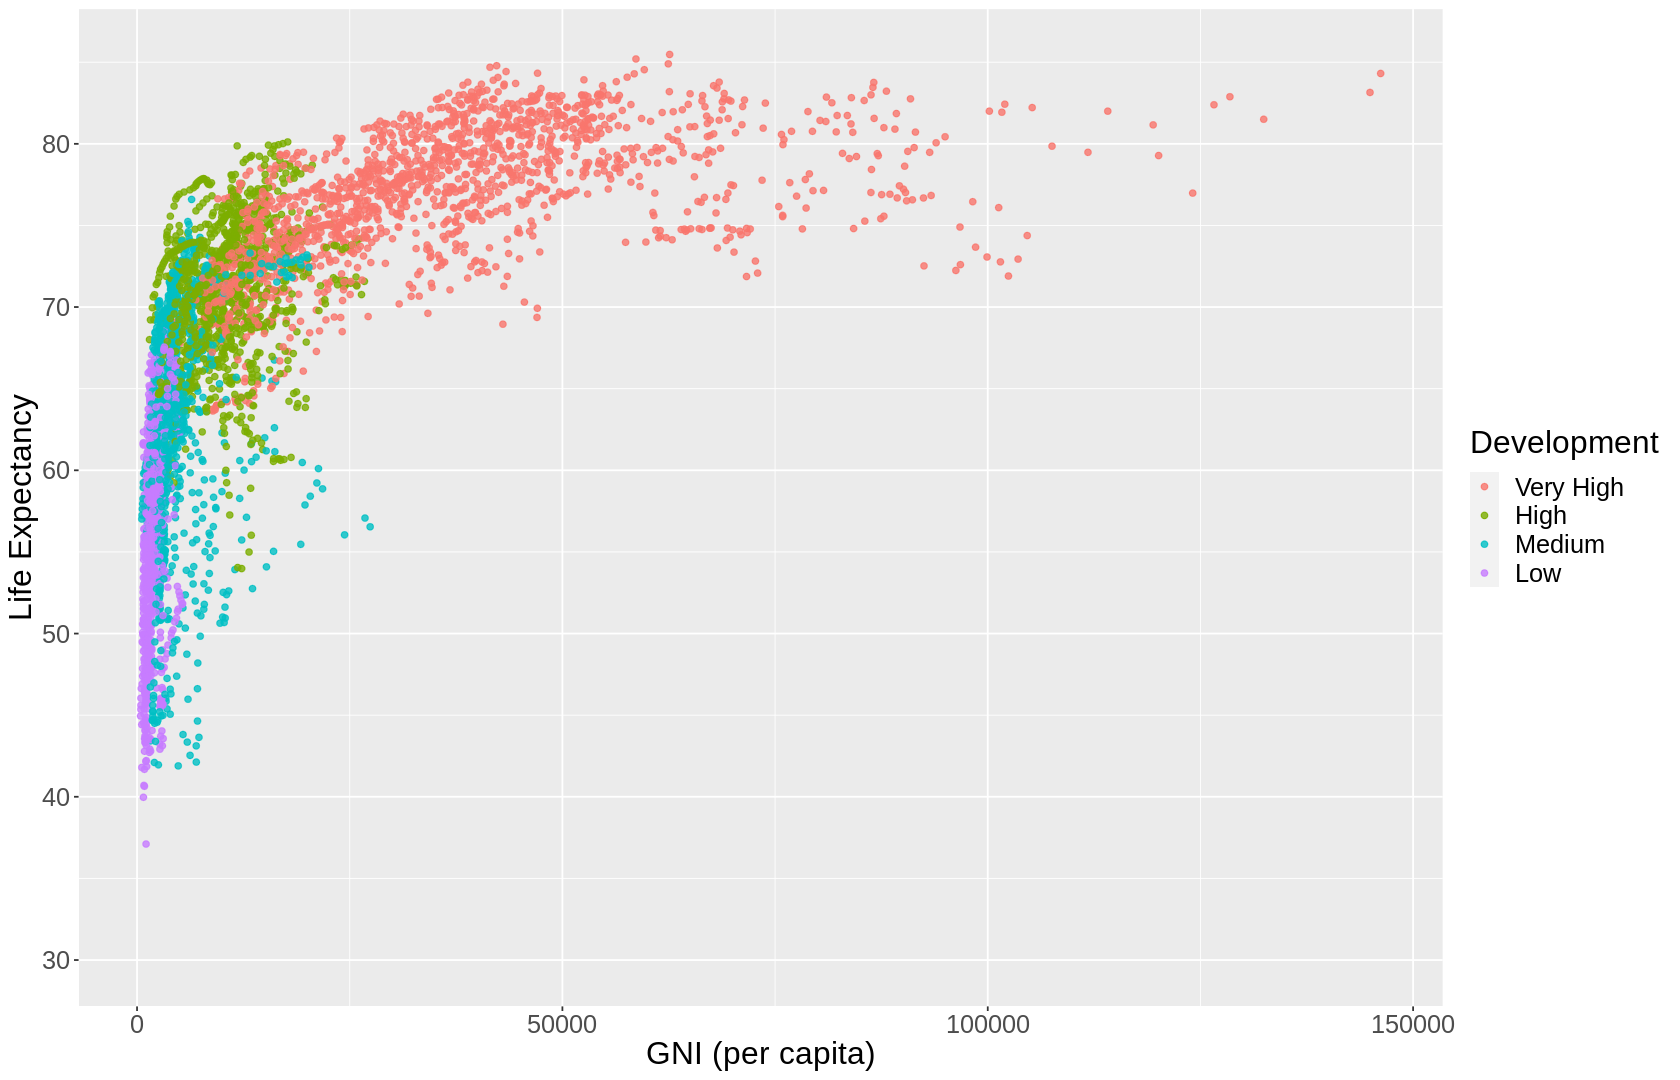

In [13]:
gni_plot

#### Plot life expectancy against poverty rate:

Warning message:
“Removed 3260 rows containing missing values (geom_point).”


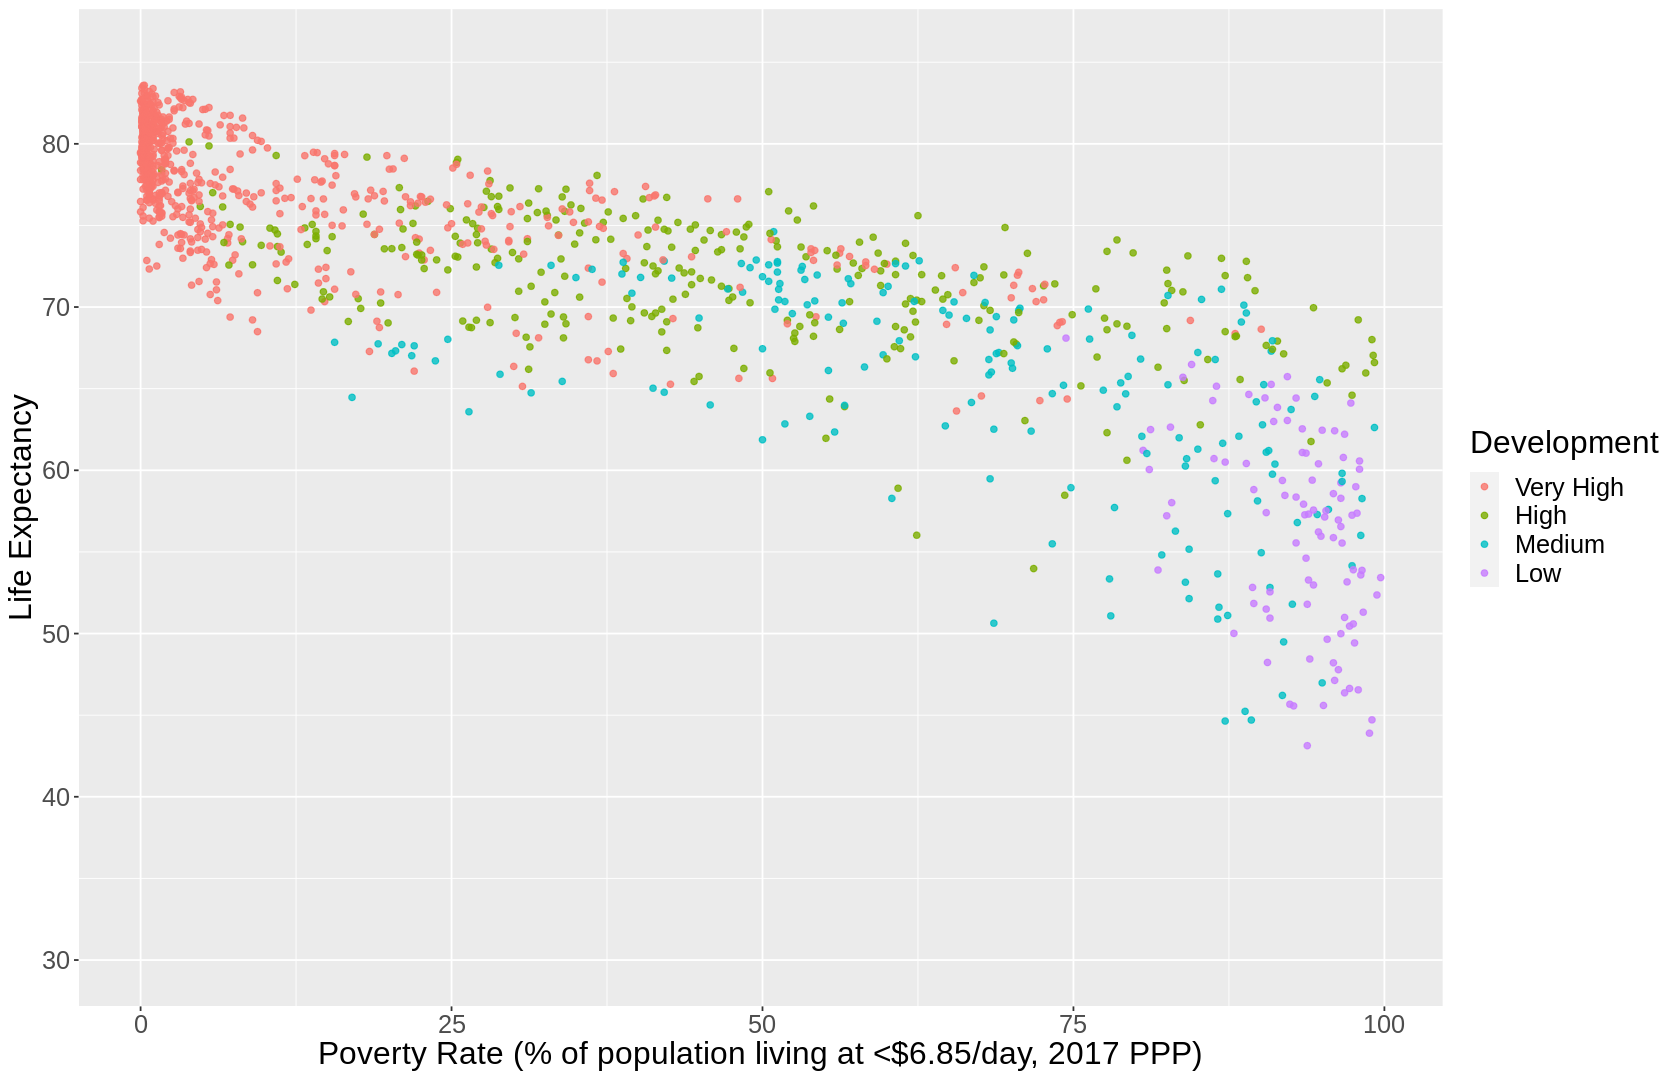

In [18]:
poverty_plot

#### Plot life expectancy against the mean years of schooling:

Warning message:
“Removed 317 rows containing missing values (geom_point).”


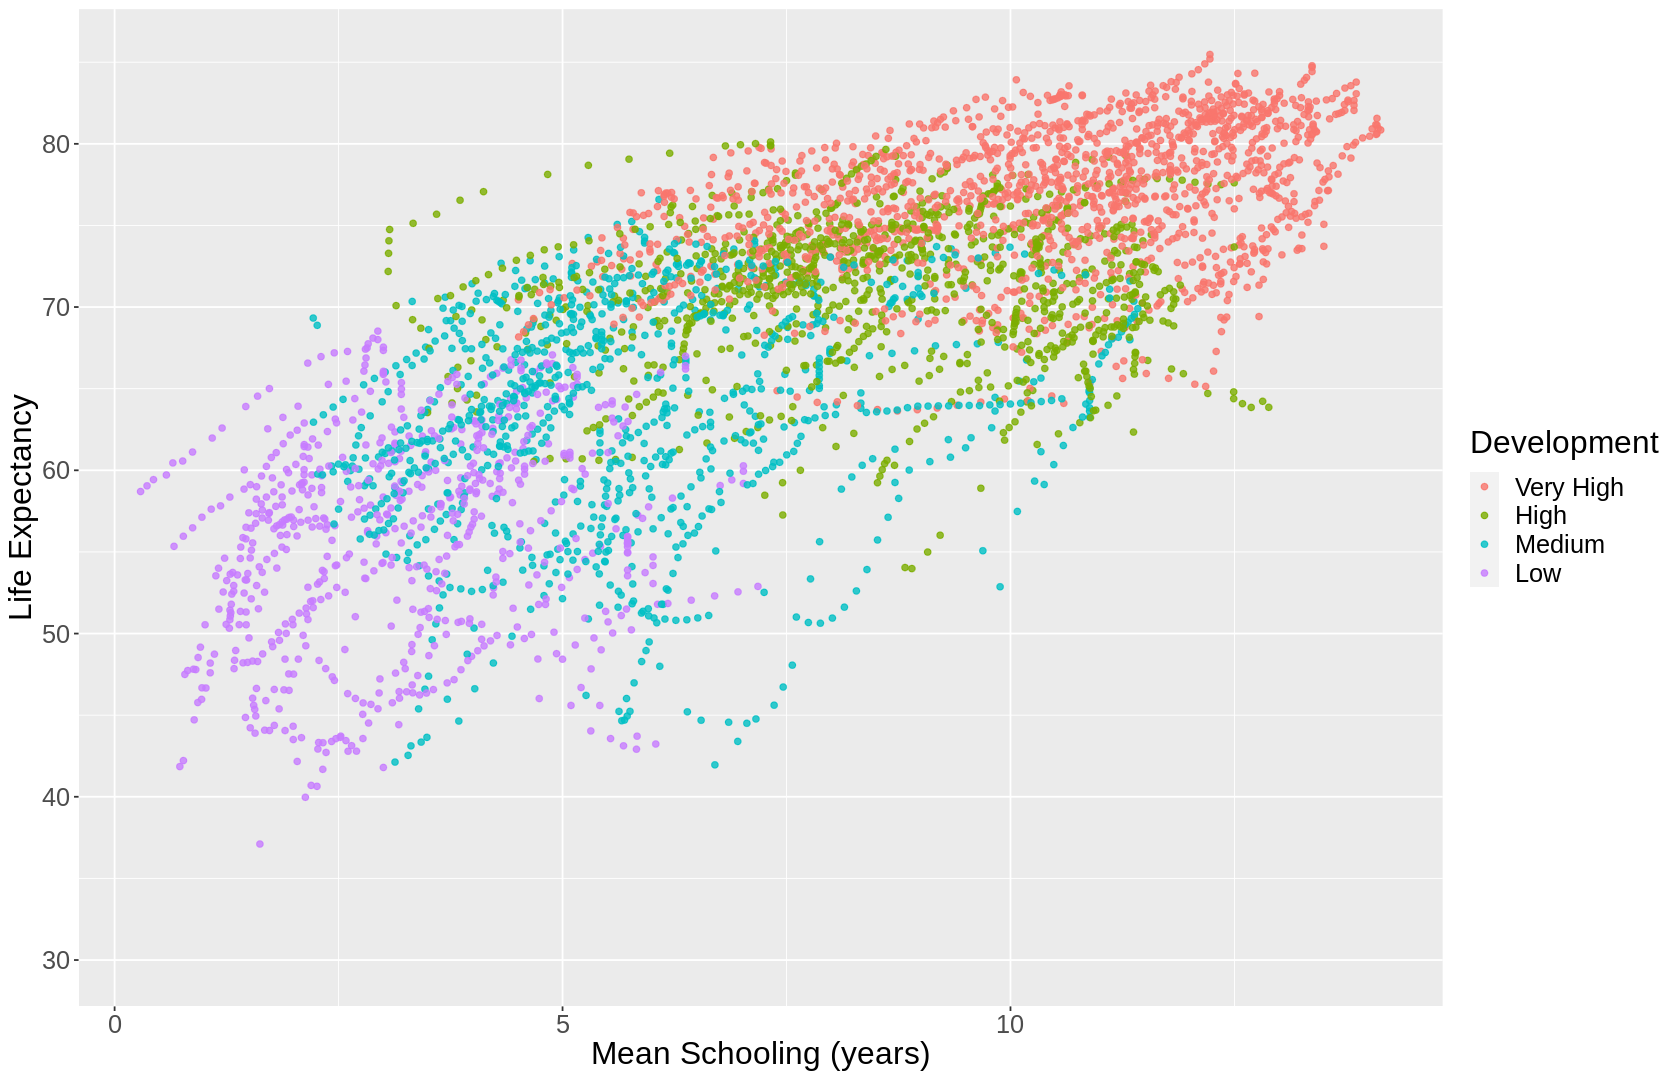

In [15]:
schooling_plot

#### Plot life expectancy against CO<sub>2</sub> emissions (tonnes per capita):

Warning message:
“Removed 39 rows containing missing values (geom_point).”


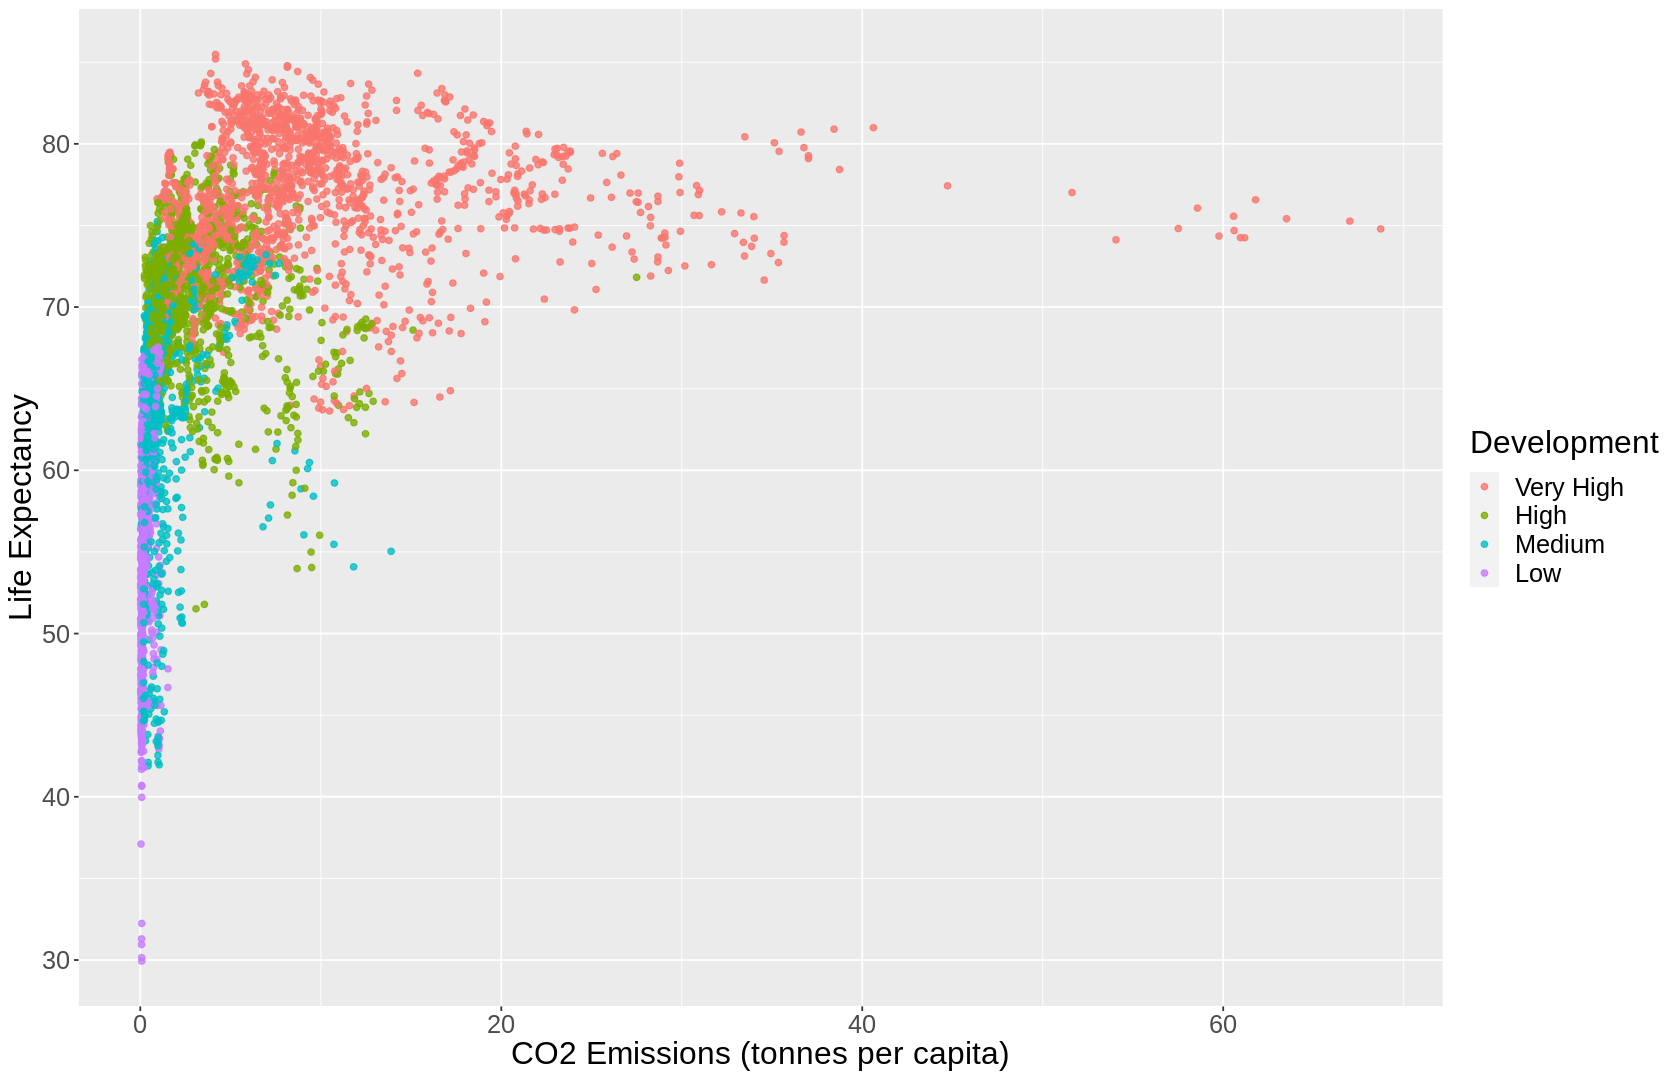

In [16]:
co2_plot

### Methods: 
We will combine the two datasets, one from United Nations Development Programme and world bank and one from United Nations Development Programme.

We will select 5 columns, Carbon dioxide emissions per capita (production), Mean years of schooling, Gross national income (GNI) per capita, Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population), and Life expectancy at birth. 

We will combine countries with very high human development and high human devlopment into high human developed countries and also combine countries with medium human development and low human development into low human developed countries. 

Carbon dioxide emissions per capita (production), Mean years of schooling, Gross national income (GNI) per capita, Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population) are varibales that we will use to predict Life expectancy at birth. 

We will use scatterplot graphs to visualize the results. We will make 4 scatterplots graph for life expectancy at birth vs factors respectively; one for carbon dioxide emissions per capita (production), one for mean years of schooling, one for gross national income (GNI) per capita, and one for poverty headcount ratio at $6.85 a day (2017 PPP) (% of population) .

### Methods: 
We expect to find the relationship between the 4 socioeconomic factors and life expectancy at birth. 

We also expect to use the data of the 4 socioeconomic factors to predict Life expectancy at birth. Our hypothesis is that mean years of schooling and gross national income decrease life expectancy at birth and poverty ratio and carbon dioxide emissions decrease life expectancy at birth. 

These findings will enable us to compare the life expectancy at birth between high human developed countries and low human developed countries. We can also .... (TO DO) 

The future question is that how can low human developed countries increase their life expectancy at birth? 